In [1]:
import sys
sys.path.append("..")
from pathlib import Path
import pandas as pd
import numpy as np
from pandas.util.testing import assert_frame_equal

from statsmodels.tsa.stattools import acf, adfuller
from statsmodels.tsa.ar_model import AR
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.seasonal import seasonal_decompose
import joblib
from pmdarima.arima import auto_arima
from sklearn.metrics import accuracy_score, mean_absolute_error, mean_squared_error, confusion_matrix

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

# from btc_predictor.utils import preproc
from btc_predictor.datasets import DataReader

mpl.rcParams['figure.figsize'] = [16.0, 9.0]
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [2]:
data = DataReader(data_file="../btc_predictor/datasets/btcusd.csv")
df = data.pd

In [3]:
# BTCUSD  = preproc(df.copy())
BTCUSD = df.copy()
BTCUSD['log_ret'] = np.log(BTCUSD.Close) - np.log(BTCUSD.Close.shift(1))

BTCUSD['baseline_Close'] = BTCUSD.Close.shift(1)
BTCUSD['baseline_log_ret'] = np.log(BTCUSD.baseline_Close) - np.log(BTCUSD.baseline_Close.shift(1))
BTCUSD.dropna(inplace=True)

# 1. Establishing Baseline

In [4]:
np.sqrt(mean_absolute_error(BTCUSD.Close, BTCUSD.baseline_Close))

9.503467908544355

In [5]:
BTCUSD.Close.describe()

count     2272.000000
mean      2644.055982
std       3528.427729
min         68.430000
25%        358.997500
50%        650.750000
75%       4101.740000
max      19497.400000
Name: Close, dtype: float64

Due to the wild fluctuations of BTCUSD prices, from \$700s at the beginning of our data stream to \$10,000s towards the end, root mean squared error become an useless metric as the former erorr will miniscule compare to the later errors. Instead, we will look at the RMSE of the normalized and stationary log return.

In [6]:
np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret))

0.061622837309947505

The loss is around 5%, which means the prior day return is an extremely great predictor of current day return. It would be hard to beat that. But the story will change if we look at the directions of the return. The direction of the return is more important than the magnitude of the return, i.e., a trade will be money losing when the direction is wrong.

In [7]:
print("Baseline RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                np.sqrt(mean_squared_error(BTCUSD.log_ret, BTCUSD.baseline_log_ret)),
                                accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))))

Baseline RMSE is 0.0616, directional accuracy is 0.4912


In [8]:
accuracy_score(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret))

0.49119718309859156

As expected, the direction of prior day log returns is a poor predictor of the direction of current day log returns. While we can obsess with minimizing the RMSE to get a 'better' prediction, we won't be able to capitalize on that prediction until we get the direction right. Thus, it would be economically more important to obtain a better direction prediction than a better magnitude direction.

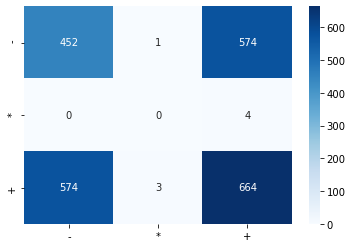

In [9]:
df_cm = pd.DataFrame(confusion_matrix(np.sign(BTCUSD.log_ret), np.sign(BTCUSD.baseline_log_ret)),  
                     index = [i for i in "-*+"],
                     columns = [i for i in "-*+"])
sns.heatmap(df_cm, annot=True, cmap='Blues', fmt='g');

## 1.2 Autoregressive (AR) Model

In [10]:
train = BTCUSD.iloc[0:1700, :]['log_ret']
test = BTCUSD.iloc[1700:, :]['log_ret']

In [11]:
ar = AR(train, freq='D').fit()

y_pred = ar.predict(test.index[0], test.index[-1], dynamic=True)
assert len(y_pred) == test.shape[0]

In [12]:
print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                                        np.sqrt(mean_squared_error(y_pred, test)),
                                                        accuracy_score(np.sign(test), np.sign(y_pred))))

Prediction RMSE is 0.0427, directional accuracy is 0.5262


## 1.3 Univariate Autoregressive integrated Moving Average (ARIMA) Model

In [13]:
def metrics(y, y_pred):
    print("Prediction RMSE is {:.4f}, directional accuracy is {:.4f}".format(
                                        np.sqrt(mean_squared_error(y, y_pred)),
                                        accuracy_score(np.sign(y), np.sign(y_pred))))
    pass

In [14]:
stepwise_model = auto_arima(train, start_p=0, start_q=0, max_d=5,
                           max_p=5, max_q=30, m=12,
                           start_P=0, max_order=20, random_state=78, seasonal=False,
                           d=1, D=1, trace=True, information_criterion='aicc',
                           error_action='ignore', stationary=False, 
                           suppress_warnings=True, 
                           stepwise=True, maxiter=100, n_jobs=24)

Performing stepwise search to minimize aicc
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=-4656.608, BIC=-4645.732, Time=0.098 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=-5090.656, BIC=-5074.342, Time=0.093 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=-5801.509, BIC=-5785.196, Time=0.906 seconds
Near non-invertible roots for order (0, 1, 1)(0, 0, 0, 0); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.993)
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=-4658.608, BIC=-4653.170, Time=0.061 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=-5298.299, BIC=-5276.548, Time=0.135 seconds
Fit ARIMA(3,1,0)x(0,0,0,0) [intercept=True]; AIC=-5459.258, BIC=-5432.069, Time=0.360 seconds
Fit ARIMA(4,1,0)x(0,0,0,0) [intercept=True]; AIC=-5547.184, BIC=-5514.557, Time=0.818 seconds
Fit ARIMA(5,1,0)x(0,0,0,0) [intercept=True]; AIC=-5621.953, BIC=-5583.888, Time=0.975 seconds
Fit ARIMA(5,1,1)x(0,0,0,0) [intercept=True]; 

In [15]:
stepwise_model.fit(train)

ARIMA(maxiter=100, method='lbfgs', order=(0, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

In [16]:
walk_forward = stepwise_model.predict(n_periods=30)

In [17]:
metrics(test[:30], walk_forward)

Prediction RMSE is 0.0754, directional accuracy is 0.5333


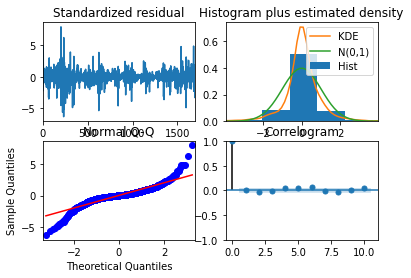

In [18]:
stepwise_model.plot_diagnostics();

It seems like the predictive power quickly diminishes to just using last price after a few forward periods. Let's look at how the predictive power of the first 7 periods.

That's super interesting. Perhaps the RNGesus favored us there. Let's just use a rolling 60 day window for training to predict the next 9 period price.

In [19]:
arima_no_diff = auto_arima(BTCUSD.iloc[0:1700, :]['Close'], start_p=0, start_q=0, max_d=5,
                           max_p=5, max_q=30, m=12,
                           start_P=0, max_order=20, random_state=78, seasonal=False,
                           d=1, D=1, trace=True, information_criterion='aicc',
                           error_action='ignore', stationary=False, 
                           suppress_warnings=True, 
                           stepwise=True, maxiter=100, n_jobs=24)

Performing stepwise search to minimize aicc
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=True]; AIC=22297.428, BIC=22308.303, Time=0.026 seconds
Fit ARIMA(1,1,0)x(0,0,0,0) [intercept=True]; AIC=22208.771, BIC=22225.085, Time=0.052 seconds
Fit ARIMA(0,1,1)x(0,0,0,0) [intercept=True]; AIC=22174.366, BIC=22190.679, Time=0.085 seconds
Fit ARIMA(0,1,0)x(0,0,0,0) [intercept=False]; AIC=22299.248, BIC=22304.686, Time=0.014 seconds
Fit ARIMA(1,1,1)x(0,0,0,0) [intercept=True]; AIC=22144.658, BIC=22166.409, Time=0.680 seconds
Fit ARIMA(2,1,1)x(0,0,0,0) [intercept=True]; AIC=22153.406, BIC=22180.595, Time=0.196 seconds
Fit ARIMA(1,1,2)x(0,0,0,0) [intercept=True]; AIC=22162.133, BIC=22189.322, Time=0.341 seconds
Fit ARIMA(0,1,2)x(0,0,0,0) [intercept=True]; AIC=22160.648, BIC=22182.399, Time=0.527 seconds
Fit ARIMA(2,1,0)x(0,0,0,0) [intercept=True]; AIC=22151.761, BIC=22173.512, Time=0.088 seconds
Fit ARIMA(2,1,2)x(0,0,0,0) [intercept=True]; AIC=22102.392, BIC=22135.018, Time=1.314 seconds
Fit ARIMA(3,1,2

In [20]:
arima_no_diff.fit(BTCUSD.iloc[0:1700, :]['Close'])

ARIMA(maxiter=100, method='lbfgs', order=(5, 1, 1), out_of_sample_size=0,
      scoring='mse', scoring_args=None, seasonal_order=(0, 0, 0, 0),
      start_params=None, suppress_warnings=True, trend=None,
      with_intercept=True)

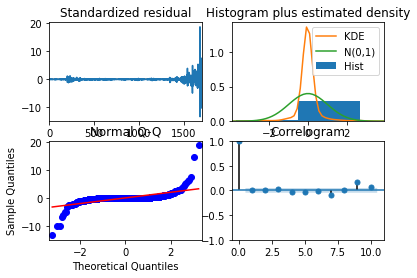

In [28]:
arima_no_diff.plot_diagnostics();

In [33]:
walk_forward = arima_no_diff.predict(n_periods=90)
metrics(BTCUSD.iloc[1700:, :]['Close'][:90], walk_forward)

Prediction RMSE is 3324.4253, directional accuracy is 1.0000


In [34]:
walk_forward

array([13562.52576359, 13217.9254487 , 12980.0518211 , 13322.21635562,
       12930.00199951, 13059.7151189 , 12819.48204358, 12966.62024536,
       12936.35696447, 12896.38712617, 12924.8470672 , 12863.145489  ,
       12950.38861955, 12895.20591909, 12936.21361468, 12913.49878741,
       12932.56868497, 12946.0548257 , 12939.35771626, 12960.31849721,
       12951.4495142 , 12973.64618602, 12971.44290648, 12983.72375485,
       12988.88477952, 12995.43387344, 13006.07476021, 13009.68297433,
       13020.60368667, 13024.89266793, 13034.62042708, 13040.87241449,
       13048.60878461, 13056.28763917, 13063.03105837, 13071.3618366 ,
       13077.94194134, 13086.05745376, 13092.99175922, 13100.6973713 ,
       13108.06501207, 13115.41518947, 13123.00843498, 13130.23760797,
       13137.86644881, 13145.1389726 , 13152.67794202, 13160.05047429,
       13167.4951738 , 13174.94694798, 13182.33826477, 13189.81589767,
       13197.20233213, 13204.66968805, 13212.07654697, 13219.52003127,
      

In [35]:
BTCUSD.iloc[1700:, :]['Close'][:30]

Date
2017-12-25    14026.6
2017-12-26    16099.8
2017-12-27    15838.5
2017-12-28    14606.5
2017-12-29    14656.2
2017-12-30    12952.2
2017-12-31    14156.4
2018-01-01    13657.2
2018-01-02    14982.1
2018-01-03    15201.0
2018-01-04    15599.2
2018-01-05    17429.5
2018-01-06    17527.0
2018-01-07    16477.6
2018-01-08    15170.1
2018-01-09    14595.4
2018-01-10    14973.3
2018-01-11    13405.8
2018-01-12    13980.6
2018-01-13    14360.2
2018-01-14    13772.0
2018-01-15    13819.8
2018-01-16    11490.5
2018-01-17    11188.6
2018-01-18    11474.9
2018-01-19    11607.4
2018-01-20    12899.2
2018-01-21    11600.1
2018-01-22    10931.4
2018-01-23    10868.4
Name: Close, dtype: float64